In [3]:
import subprocess
import numpy as np
import simplifier
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('axes', titlesize=12, labelsize=12)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

core_maths/
4
5
6
7
8
9
10
osc_maths/
4
5
6
7
8
9
10
ext_maths/
4
5
6
7
8
9
10


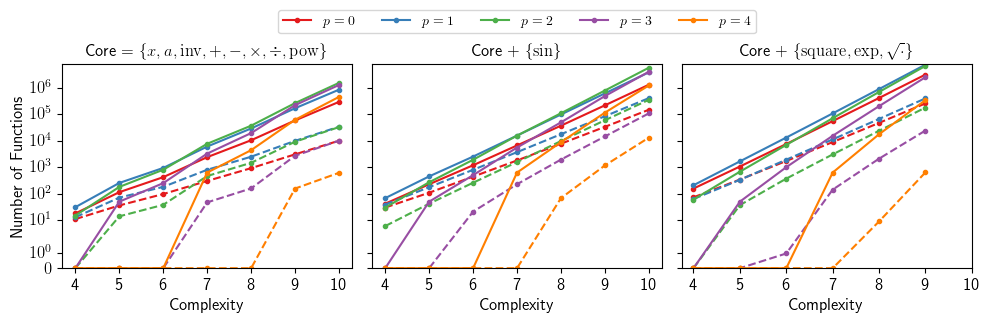

In [12]:
def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE,
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])


def count_fun(fname):

    ntotal = file_len(fname)
    with open(fname, "r") as f:
        all_fun = f.read().splitlines()
    assert ntotal == len(all_fun), 'Maybe missing some equations'
    max_param = simplifier.get_max_param(all_fun, verbose=False)
    nparam = simplifier.count_params(all_fun, max_param)
    count = np.empty(max_param + 1, dtype=int)
    for i in range(len(count)):
        count[i] = (nparam == i).sum()
    assert ntotal == count.sum(), 'Count does not match total'

    return count

all_compl = np.arange(4, 11)
# all_compl = np.arange(4, 8)
all_dirname = ['core_maths/', 'osc_maths/', 'ext_maths/']
all_ops = [r'Core = $\{x, a, {\rm inv}, +, -, \times, \div, {\rm pow} \}$',
          r'Core + $\{ \sin \}$',
          r'Core + $\{ {\rm square}, \exp, \sqrt{\cdot} \}$']
nfortab = 4

fig, axs = plt.subplots(1, 3, figsize=(10,3), sharey=True)
cm = plt.get_cmap('Set1')

for i in range(len(all_dirname)):
    
    dirname = all_dirname[i]
    ops = all_ops[i]

    all_total = []
    all_uniq = []
    
    print(dirname)

    for compl in all_compl:

        print(compl)

        try:
            fname = dirname + '/compl_%i/all_equations_%i.txt'%(compl,compl)
            total_count = count_fun(fname)

            fname = dirname + '/compl_%i/unique_equations_%i.txt'%(compl,compl)
            uniq_count = count_fun(fname)

            if (len(uniq_count) < nfortab+1) or (len(total_count) < nfortab+1):
                t = np.zeros(nfortab+1, dtype=int)
                t[:len(uniq_count)] = uniq_count
                uniq_count = t

                t = np.zeros(nfortab+1, dtype=int)
                t[:len(total_count)] = total_count
                total_count = t

            all_total.append([x for x in total_count[:nfortab+1]])
            all_uniq.append([x for x in uniq_count[:nfortab+1]])

        except:
            pass
        
#     print(all_total)
#     print(all_uniq)

    all_total = np.array(all_total, dtype=int)
    all_uniq = np.array(all_uniq, dtype=int)
    
    for j in range(all_total.shape[1]):
        c = cm(j)
        axs[i].plot(all_compl[:all_total.shape[0]], all_total[:,j], color=c, marker='.', label=r'$p = %i$'%j)
        axs[i].plot(all_compl[:all_total.shape[0]], all_uniq[:,j], color=c, ls='--', marker='.')
        
    axs[i].set_xlabel('Complexity')
    axs[i].set_title(ops)
    
    axs[i].set_xticks(all_compl)
    axs[i].set_xticklabels(all_compl)

axs[0].set_yscale('symlog')
axs[0].set_ylabel('Number of Functions')
axs[0].set_ylim(0, None)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=nfortab+1, fancybox=True)
fig.savefig('figs/count_functions.pdf', bbox_inches='tight', transparent=True)